## DOWNSTREAM SIGNALING DYNAMICS

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from msresist.pca import plotPCA

In [2]:
# Set plotting format
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

## Import and Preprocess Data

In [3]:
ts = pd.read_csv("msresist/data/Validations/Luminex/AXLm_TimeSeries_Signaling.csv")
ts.iloc[:, 3:] = pd.DataFrame(StandardScaler().fit_transform(ts.iloc[:, 3:]))
cell_lines = list(ts[(ts["Treatment"] == "UT")]["Cell Line"])
tps = sorted(list(set(ts["Time point"])))
prots = list(ts.columns[3:])

## Overview of key data

Text(0.5, 0, 'Min')

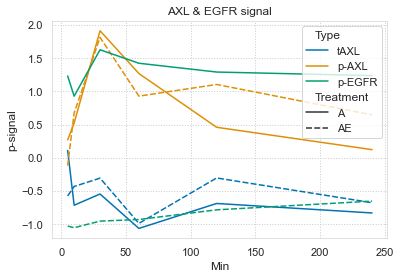

In [125]:
axl = ts[(ts["Cell Line"] == "WT") & (ts["Treatment"] != "UT")].set_index(["Time point", "Treatment"])[["tAXL", "p-AXL", "p-EGFR"]].reset_index()
axl = pd.melt(frame=axl, id_vars=["Time point", "Treatment"], value_vars=axl.columns[1:], value_name="p-signal", var_name="Type")

_, ax = plt.subplots(1, 1)
sns.lineplot(data=axl, x="Time point", y="p-signal", hue="Type", style="Treatment", ax=ax)
ax.set_title("AXL & EGFR signal")
ax.set_xlabel("Min")

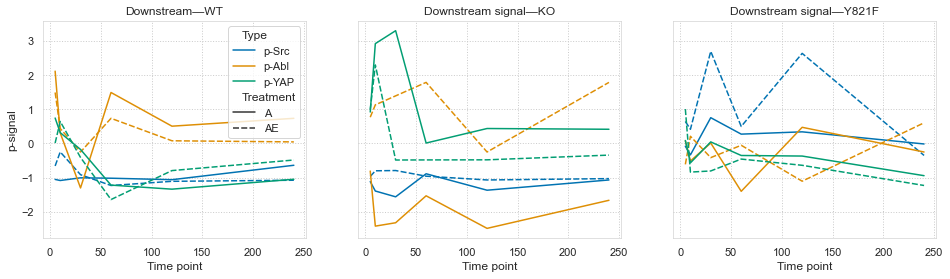

In [136]:
dWT = ts[(ts["Cell Line"] == "WT") & (ts["Treatment"] != "UT")].set_index(["Time point", "Treatment"])[["p-Src", "p-Abl", "p-YAP"]].reset_index()
dWT = pd.melt(frame=dWT, id_vars=["Time point", "Treatment"], value_vars=dWT.columns[1:], value_name="p-signal", var_name="Type")
dKO = ts[(ts["Cell Line"] == "KO") & (ts["Treatment"] != "UT")].set_index(["Time point", "Treatment"])[["p-Src", "p-Abl", "p-YAP"]].reset_index()
dKO = pd.melt(frame=dKO, id_vars=["Time point", "Treatment"], value_vars=dKO.columns[1:], value_name="p-signal", var_name="Type")
d821 = ts[(ts["Cell Line"] == "Y821F") & (ts["Treatment"] != "UT")].set_index(["Time point", "Treatment"])[["p-Src", "p-Abl", "p-YAP"]].reset_index()
d821 = pd.melt(frame=d821, id_vars=["Time point", "Treatment"], value_vars=d821.columns[1:], value_name="p-signal", var_name="Type")

_, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.lineplot(data=dWT, x="Time point", y="p-signal", hue="Type", style="Treatment", ax=ax[0])
ax[0].set_title("Downstream—WT")

sns.lineplot(data=dKO, x="Time point", y="p-signal", hue="Type", style="Treatment", ax=ax[1])
ax[1].set_title("Downstream signal—KO")
ax[1].legend().remove()

sns.lineplot(data=d821, x="Time point", y="p-signal", hue="Type", style="Treatment", ax=ax[2])
ax[2].set_title("Downstream signal—Y821F")
ax[2].legend().remove()

-Check p-SRC in the AXL MS data

In [140]:
wt = ts[(ts["Cell Line"] == "WT") | (ts["Cell Line"] == "KO") | (ts["Cell Line"] == "UT")]

In [141]:
wt.head()

,Cell Line,Treatment,Time point,p-MEK,p-JNK,p-Erk,p-Src,p-Abl,p-mTOR,p-Stat3,Akt,p-YAP,tAXL,p-AXL,p-EGFR
0,WT,UT,0,-0.542229,-0.328030,0.420849,-1.095502,1.524257,-0.277902,1.549152,-0.363393,-1.457371,0.945865,-0.999484,2.450583
1,WT,A,5,2.265447,2.830781,0.156121,-1.055999,2.116546,0.519474,2.771814,2.017603,0.742739,0.110949,0.270895,1.232343
2,WT,AE,5,0.706666,0.279433,1.744485,-0.660972,1.491352,1.848434,0.501157,-0.192466,0.010290,-0.572693,-0.115587,-1.026351
3,WT,A,10,1.584232,0.522419,0.597333,-1.087601,0.306775,0.887494,0.195491,1.454743,0.314326,-0.712331,0.524971,0.929299
4,WT,AE,10,-0.408657,0.765404,0.067879,-0.250143,0.438395,0.734152,-0.197507,0.295273,0.643237,-0.430146,0.675269,-1.050594


No handles with labels found to put in legend.


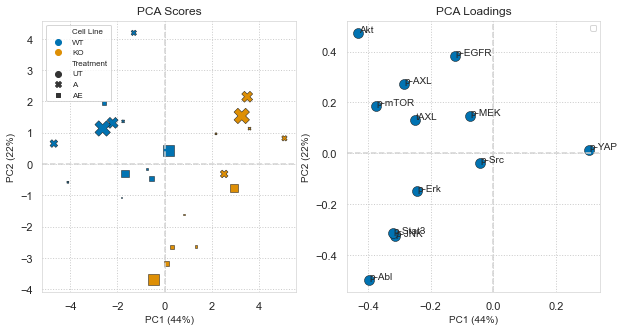

In [154]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotPCA(ax, wt, 2, ["Cell Line", "Treatment"], wt.columns[3:], hue_scores="Cell Line", style_scores="Treatment", size_dots=list(wt["Time point"]))

## TENSOR DECOMPOSITION

In [7]:
from tensorly.decomposition import parafac, non_negative_parafac
import tensorly as tl

### 1. Treatment (2) x Cell Line (10) x Time point (7) x Analyte (12) Tensor

### 1A) Full model

In [209]:
a = ts[(ts["Treatment"] == "UT") | (ts["Treatment"] == "A")].iloc[:, 3:].values.reshape((10, 7, 12))
ae = ts[(ts["Treatment"] == "UT") | (ts["Treatment"] == "AE")].iloc[:, 3:].values.reshape((10, 7, 12))
out_full = np.array([a, ae])
print(out_full.shape)

(2, 10, 7, 12)


0.38658104382667546


Text(0.5, 1.0, 'p-sites')

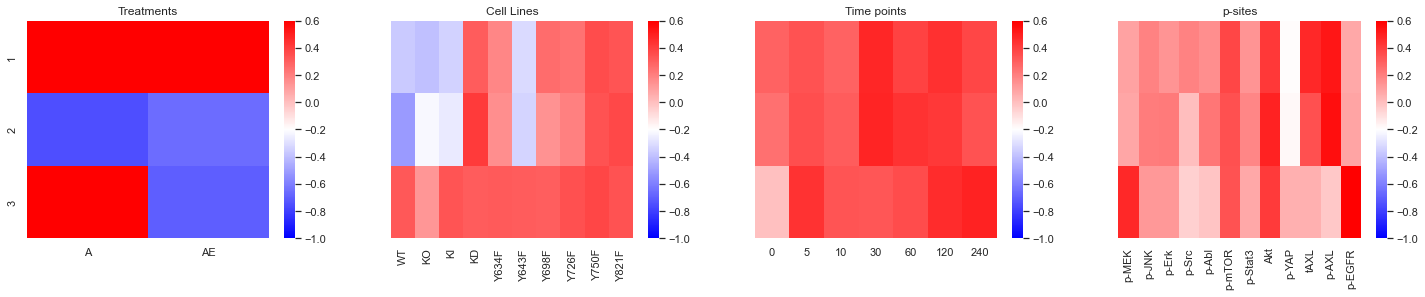

In [231]:
out = out_full

comp = 3
fac = parafac(out, comp, tol=1e-9, n_iter_max=5000, init="random", random_state=0)
fac = tl.cp_tensor.cp_flip_sign(fac)
fac.normalize()

# data variance
dvar = np.sum(np.square(out))
diffvar = np.sum(np.square(out - tl.cp_to_tensor(fac)))

# R2X
print(1.0 - diffvar / dvar)

comps = np.arange(comp) + 1 

# Plot
_, ax = plt.subplots(1, 4, figsize=(25, 4), sharey=True)

#Treatments
treatW = pd.DataFrame(fac.factors[0])
treatW.columns = comps
treatW.index = ["A", "AE"]
ax[0].set_title("Treatments")
ax[0].set_ylabel("Component")
sns.heatmap(treatW.T, ax=ax[0], vmin=-1, vmax=0.6, cmap="bwr")

# Cell Lines
mutsW = pd.DataFrame(fac.factors[1])
mutsW.columns = comps
mutsW.index = cell_lines
sns.heatmap(mutsW.T, ax=ax[1], vmin=-1, vmax=0.6, cmap="bwr")
ax[1].set_title("Cell Lines")

# Time points
tpW = pd.DataFrame(fac.factors[2])
tpW.columns = comps
tpW.index = tps
sns.heatmap(tpW.T, ax=ax[2], vmin=-1, vmax=0.6, cmap="bwr")
ax[2].set_title("Time points")

# Proteins
pW = pd.DataFrame(fac.factors[3])
pW.columns = comps
pW.index = prots
sns.heatmap(pW.T, ax=ax[3], vmin=-1, vmax=0.6, cmap="bwr")
ax[3].set_title("p-sites")

### 1A) AF154 only

0.46003800138086715


Text(0.5, 1.0, 'p-sites')

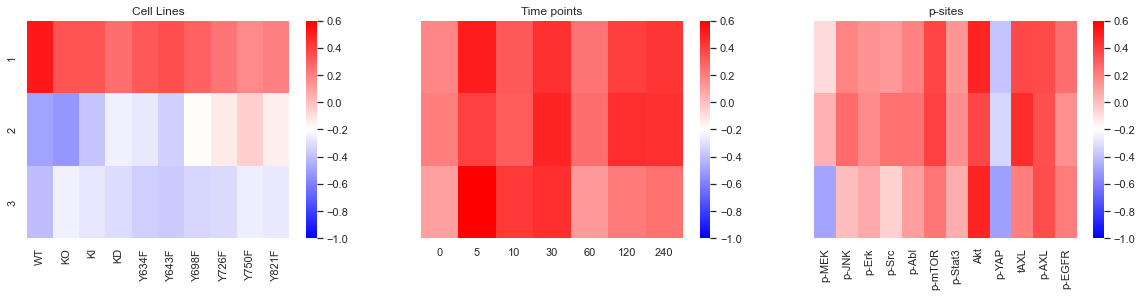

In [233]:
out = a

comp = 3
fac = parafac(out, comp, tol=1e-9, n_iter_max=5000, random_state=0)
fac = tl.cp_tensor.cp_flip_sign(fac)
fac.normalize()

# data variance
dvar = np.sum(np.square(out))
diffvar = np.sum(np.square(out - tl.cp_to_tensor(fac)))

# R2X
print(1.0 - diffvar / dvar)

comps = np.arange(comp) + 1 

# Plot
_, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)

# Cell Lines
mutsW = pd.DataFrame(fac.factors[0])
mutsW.columns = comps
mutsW.index = cell_lines
sns.heatmap(mutsW.T, ax=ax[0], vmin=-1, vmax=0.6, cmap="bwr")
ax[0].set_title("Cell Lines")

# Time points
tpW = pd.DataFrame(fac.factors[1])
tpW.columns = comps
tpW.index = tps
sns.heatmap(tpW.T, ax=ax[1], vmin=-1, vmax=0.6, cmap="bwr")
ax[1].set_title("Time points")

# Proteins
pW = pd.DataFrame(fac.factors[2])
pW.columns = comps
pW.index = prots
sns.heatmap(pW.T, ax=ax[2], vmin=-1, vmax=0.6, cmap="bwr")
ax[2].set_title("p-sites")

### 1B) EA

0.4615999430094707


Text(0.5, 1.0, 'p-sites')

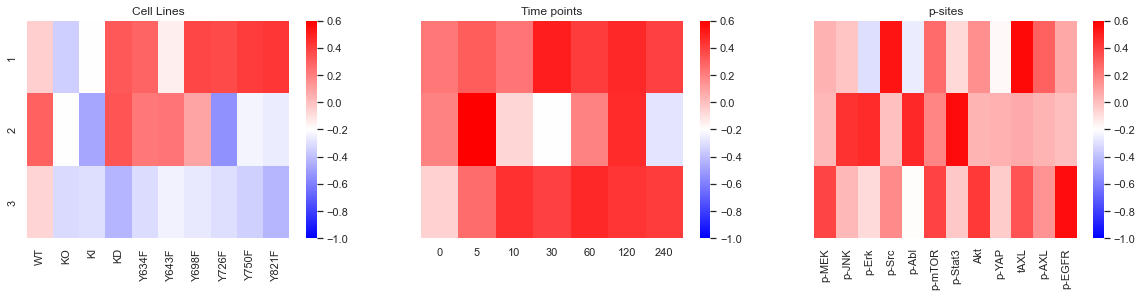

In [230]:
out = ae

comp = 3
fac = parafac(out, comp, tol=1e-9, n_iter_max=5000, random_state=0)
fac = tl.cp_tensor.cp_flip_sign(fac)
fac.normalize()

# data variance
dvar = np.sum(np.square(out))
diffvar = np.sum(np.square(out - tl.cp_to_tensor(fac)))

# R2X
print(1.0 - diffvar / dvar)

comps = np.arange(comp) + 1 

# Plot
_, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)

# Cell Lines
mutsW = pd.DataFrame(fac.factors[0])
mutsW.columns = comps
mutsW.index = cell_lines
sns.heatmap(mutsW.T, ax=ax[0], vmin=-1, vmax=0.6, cmap="bwr")
ax[0].set_title("Cell Lines")

# Time points
tpW = pd.DataFrame(fac.factors[1])
tpW.columns = comps
tpW.index = tps
sns.heatmap(tpW.T, ax=ax[1], vmin=-1, vmax=0.6, cmap="bwr")
ax[1].set_title("Time points")

# Proteins
pW = pd.DataFrame(fac.factors[2])
pW.columns = comps
pW.index = prots
sns.heatmap(pW.T, ax=ax[2], vmin=-1, vmax=0.6, cmap="bwr")
ax[2].set_title("p-sites")

### 2. Cell Line (10) x Time point & Treatment (14) x Analyte (12) Tensor

First need to duplicate rows when t=0h at the right location to be able to reshape. 

In [182]:
# Function to insert row in the dataframe
def insert_rows(row_number, df, row_value):
    # Slice the upper half of the dataframe
    df1 = df[0:row_number]
  
    # Store the result of lower half of the dataframe
    df2 = df[row_number:]
  
    # Insert the row in the upper half dataframe
    df1.loc[row_number]=row_value
  
    # Concat the two dataframes
    df_result = pd.concat([df1, df2])
  
    # Reassign the index labels
    df_result.index = [*range(df_result.shape[0])]
  
    # Return the updated dataframe
    return df_result
  
# Let's create a row which we want to insert
ut_df = ts[ts["Treatment"] == "UT"]
row_numbers = ut_df.index
row_value = ut_df

ts_ = ts.copy()
for ii, rN in enumerate(row_numbers):
    ts_ = insert_rows(rN + ii, ts_, row_value.iloc[ii, :])

out_flat = ts_.iloc[:, 3:].values.reshape((14, 10, 12))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [183]:
out_flat = ts_.iloc[:, 3:].values.reshape((14, 10, 12))

In [207]:
out = out_flat
comp = 6
fac = parafac(out, comp, tol=1e-9, n_iter_max=5000, init="svd", random_state=1)
fac = tl.cp_tensor.cp_flip_sign(fac)
fac.normalize()

# data variance
dvar = np.sum(np.square(out))
diffvar = np.sum(np.square(out - tl.cp_to_tensor(fac)))

# R2X
print(1.0 - diffvar / dvar)

0.5174620680635451


Text(0.5, 1.0, 'p-sites')

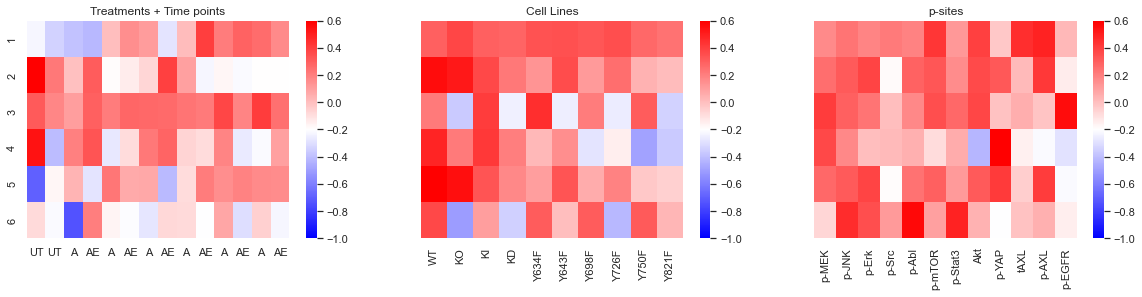

In [208]:
comps = np.arange(comp) + 1 

# Plot
_, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)

#Treatments
treatW = pd.DataFrame(fac.factors[0])
treatW.columns = comps
treatW.index = ["UT", "UT", "A", "AE", "A", "AE", "A", "AE", "A", "AE", "A", "AE" ,"A", "AE"]
sns.heatmap(treatW.T, ax=ax[0], vmin=-1, vmax=0.6, cmap="bwr")
ax[0].set_title("Treatments + Time points")

# Cell Lines
mutsW = pd.DataFrame(fac.factors[1])
mutsW.columns = comps
mutsW.index = cell_lines
sns.heatmap(mutsW.T, ax=ax[1], vmin=-1, vmax=0.6, cmap="bwr")
ax[1].set_title("Cell Lines")

# Proteins
pW = pd.DataFrame(fac.factors[2])
pW.columns = comps
pW.index = prots
sns.heatmap(pW.T, ax=ax[2], vmin=-1, vmax=0.6, cmap="bwr")
ax[2].set_title("p-sites")